# Basic gimVI tutorial
## Impute missing genes in Spatial Data from Sequencing Data

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')

In [2]:
def allow_notebook_for_test():
    print("Testing the gimvi notebook")

test_mode = False
save_path = "data/"


def if_not_test_else(x, y):
    if not test_mode:
        return x
    else:
        return y

In [3]:
from scvi.dataset import (
    DropseqDataset,
    StarmapDataset,
    GeneExpressionDataset,
    SmfishDataset,
    CortexDataset,
)
from scvi.models import JVAE, Classifier
from scvi.inference import JVAETrainer

import notebooks.utils.gimvi_tutorial as gimvi_utils

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
INFO:hyperopt.utils:Failed to load dill, try installing dill via "pip install dill" for enhanced pickling support.
INFO:hyperopt.fmin:Failed to load dill, try installing dill via "pip install dill" for enhanced pickling support.
INFO:hyperopt.mongoexp:Failed to load dill, try installing dill via "pip install dill" for enhanced pickling support.


In [4]:
import numpy as np
import copy

## Load two datasets: one with spatial data, one from sequencing

Here we load: 
- **Cortex**: a scRNA-seq dataset of 3,005 mouse somatosensory cortex cells (Zeisel et al., 2015)
- **osmFISH**: a smFISH dataset of 4,462 cells and 33 genes from the same tissue (Codeluppi et al., 2018)

In [5]:
data_spatial = SmfishDataset()
data_seq = CortexDataset(
    save_path=save_path,
    genes_fish=data_spatial.gene_names, 
    genes_to_keep=[], 
    additional_genes=0
)
if test_mode:
    data_seq = data_spatial

INFO:root:File data/osmFISH_SScortex_mouse_all_cell.loom already downloaded
INFO:root:Preprocessing smFISH dataset
INFO:root:Finished preprocessing smFISH dataset
INFO:root:File data/expression.bin already downloaded
INFO:root:Preprocessing Cortex data
INFO:root:Finished preprocessing Cortex data


Here is another pair

In [6]:
# data_spatial = StarmapDataset(file='starmap.loom')
# data_seq = DropseqDataset(genes_to_keep=data_spatial.gene_names)

**Hide some genes in the osFISH dataset to score the imputation**

In [7]:
train_size = 0.8

gene_names_rnaseq = data_seq.gene_names
np.random.seed(0)
n_genes = len(gene_names_rnaseq)
gene_ids_train = sorted(
    np.random.choice(range(n_genes), int(n_genes * train_size), False)
)
gene_ids_test = sorted(set(range(n_genes)) - set(gene_ids_train))

gene_names_fish = gene_names_rnaseq[gene_ids_train]

# Create copy of the fish dataset with hidden genes
data_spatial_partial = copy.deepcopy(data_spatial)
data_spatial_partial.filter_genes(gene_names_fish)
data_spatial_partial.batch_indices += data_seq.n_batches

INFO:root:Downsampling from 33 to 26 genes
INFO:root:Downsampling from 4462 to 4462 cells


**Configure the Joint Model**
The joint model can take multiple datasets with potentially different observed genes. 
All dataset will be encoded and decoded with the union of all genes.
It requires:
- The gene mappings from each dataset to the common decoded vector:
    * *Eg: dataset1 has genes ['a', 'b'] and dataset2 has genes ['b', 'c'], then a possible output can be ['b', 'a', 'c'] such that the mappings are [1, 0] and [0, 2]*
    * *Usually, if the genes of dataset2 are included in dataset1, it is way more efficient to keep the order of dataset1 in the output and use `slice(None)` as a mapping for dataset1*
    
- The number of inputs (ie) number of genes in each dataset
- The distributions to use for the generative process: usually scRNA-seq is modelled with ZINB (because of technical dropout) and FISH with NB or even Poisson
- Whether to model the library size with a latent variable or use the observed value

In [8]:
datasets = [data_seq, data_spatial_partial]
generative_distributions = ["zinb", "nb"]
gene_mappings = [slice(None), np.array(gene_ids_train)]
n_inputs = [d.nb_genes for d in datasets]
total_genes = data_seq.nb_genes
n_batches = sum([d.n_batches for d in datasets])

model_library_size = [True, False]

n_latent = 8
kappa = 1

In [9]:
import torch

torch.manual_seed(0)

model = JVAE(
    n_inputs,
    total_genes,
    gene_mappings,
    generative_distributions,
    model_library_size,
    n_layers_decoder_individual=0,
    n_layers_decoder_shared=0,
    n_layers_encoder_individual=1,
    n_layers_encoder_shared=1,
    dim_hidden_encoder=64,
    dim_hidden_decoder_shared=64,
    dropout_rate_encoder=0.2,
    dropout_rate_decoder=0.2,
    n_batch=n_batches,
    n_latent=n_latent,
)

discriminator = Classifier(n_latent, 32, 2, 3, logits=True)

trainer = JVAETrainer(model, discriminator, datasets, 0.95, frequency=1, kappa=kappa)

In [10]:
n_epochs = if_not_test_else(200, 1)
trainer.train(n_epochs=n_epochs)

training: 100%|██████████| 200/200 [03:50<00:00,  1.15s/it]


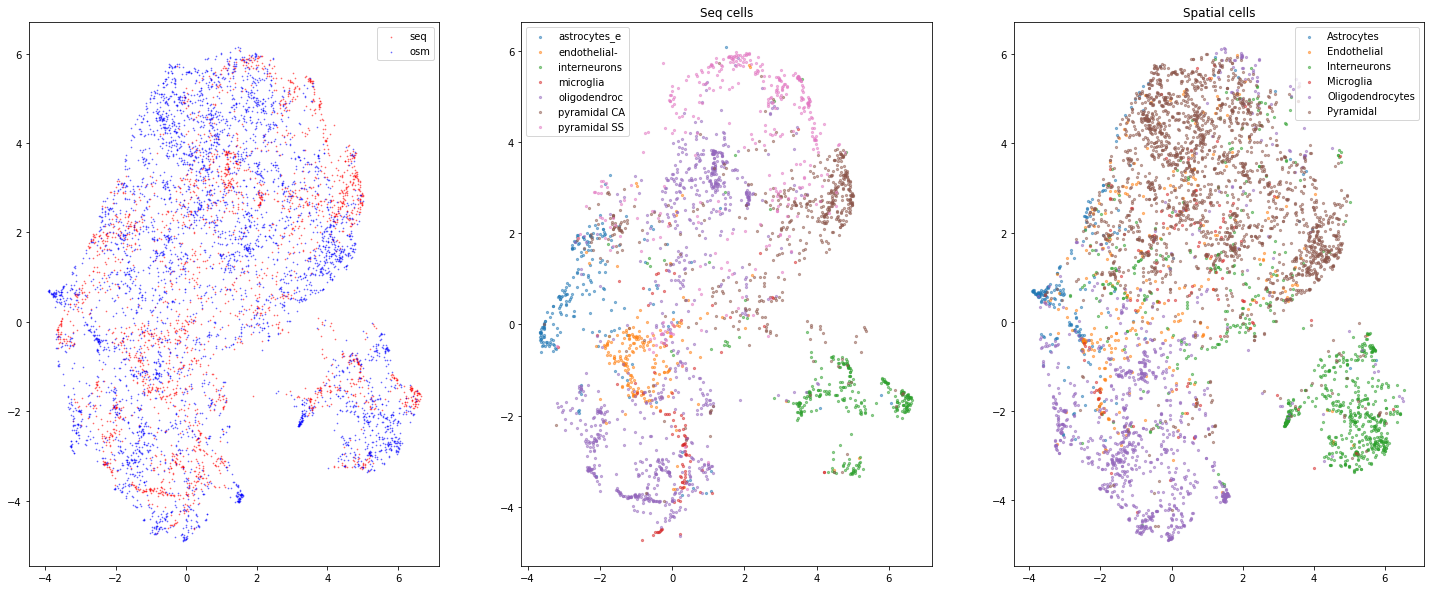

In [11]:
gimvi_utils.plot_umap(trainer)

In [12]:
gimvi_utils.imputation_score(trainer, data_spatial, gene_ids_test, True)

0.2624430009491513

### Plot imputation for *LAMP5*, hidden in the training

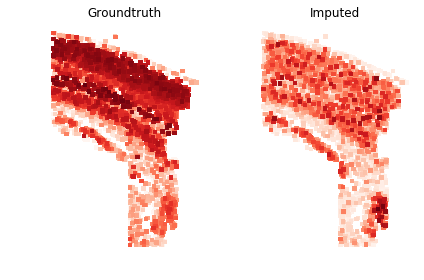

In [13]:
gimvi_utils.plot_gene_spatial(trainer, data_spatial, 9)